In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from scipy.interpolate import interp1d
import matplotlib as mpl
from tqdm import tqdm
from scipy.integrate import quad
from scipy.special import factorial, eval_hermite, comb
from qutip import *
import cvxpy as cp
import time
from joblib import Parallel, delayed

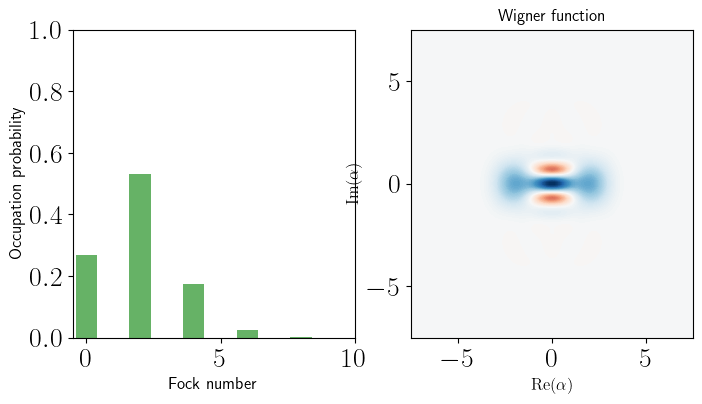

In [2]:
N=10

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)


alpha = 1.41
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = fock(N, 3) 


psi0 = tensor(initial_cavity, basis(2,0))
n_init = expect(N_cav, psi0)
plot_wigner_fock_distribution(initial_cavity);

In [3]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

In [4]:
def find_first_zero(func, tol=0.5e-2, max=2000):
    for i in np.arange(max):
        if func(i) < tol:
            return i

## Params

In [5]:
Ntrajs = 500

dt = 0.3
dt_total = 1
factor = dt_total/dt

# Constant coupling

In [6]:
# generate interaction Hamiltonian with strength gint
prng = np.random.RandomState(12775425)
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

def get_measurements_hist_Nmeas_const(rotangl, theta, kappa, n_init):
    U_int = U_interact(theta)
    # loss operator
    L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
    op = L.expm()
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    quadmeashom = []
    
    def calc_weights(step):
        return (theta/np.sqrt(2))*np.exp(-step*(theta**2/2))

    def pop_time_evol(step):
        return n_init*np.exp(-step*(theta**2))
        
    Nmeas = find_first_zero(pop_time_evol)
    
    calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

    for j in tqdm(range(Ntrajs), leave=False):
        xrnd = prng.rand(Nmeas)

        results = []
        psi = ket2dm(psi0)

        for i in range(Nmeas):
            U = qbrotmat * U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)          

            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                #results.append(-1 if error[i] <= correct_prob else 1) 
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                #results.append(1 if error[i] <= correct_prob else -1)
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
    
        quadmeashom.append(np.sum(results*calculated_weights))

    ### create histogram ###    
    hist, bins = np.histogram(quadmeashom,Nbins,[-k,k], density=True)    

    return hist

In [7]:
# homodyne setting for measurement operators
nangles = 10
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 30 # number of histogram bins
k = 5  # bin edge limit
dx =  2*k/Nbins # bin width


#######
N_large = 30 # need some additional dimensions to properly construct the noise-compensated operators

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct measurement operators
def get_Pis(theta, i):
    Pi = np.zeros((N_large,N_large),dtype=np.complex128)
    for m in range(N_large):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N_large):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=-1, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# funtions to construct vectors
def get_basis_vectors(N_large):
    # construct vectors
    basis_vectors = []
    for i in range(N_large):
        vector = fock(N_large, i)
        basis_vectors.append(np.real(vector.full()))
    
    return basis_vectors
        
def get_basis_dms(N_large, basis_vectors):    
    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector1, vector2)
            basis_dms.append(dm)
            
    return basis_dms

basis_vectors  = get_basis_vectors(N_large) # needed for the adjusted operators
basis_dms = get_basis_dms(N_large, basis_vectors)

basis_vectors_cut = get_basis_vectors(N)
basis_dms_cut = get_basis_dms(N, basis_vectors_cut)

        
### Construct noise adjusted measurement operators
def B(n,k, eta):
    return np.sqrt(comb(n+k,n) * eta**n * (1-eta)**k)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 298 out of 300 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.5s finished


In [13]:
#### EXTERNAL LOSS RATE KAPPA ###########
kappa = 0.005

##### EFFECTIVE INTERACTION STRENGTH
theta_int = 0.2*np.pi/2

gamma = theta_int**2/dt
gamma_effective = gamma/factor 

# choose to run with or without noise/loss compensation
noise_comp = True

if noise_comp == True:
    # Efficiency eta
    eta = gamma_effective/(gamma_effective + kappa) 
else:
    eta = 1


print("eta", eta, 'gamma', gamma,gamma_effective/(gamma_effective + kappa) )

eta 0.9517821528517063 gamma 0.32898681336964525 0.9517821528517063


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   34.8s remaining:  2.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   38.7s finished


CPU times: user 6.09 s, sys: 851 ms, total: 6.94 s
Wall time: 45 s


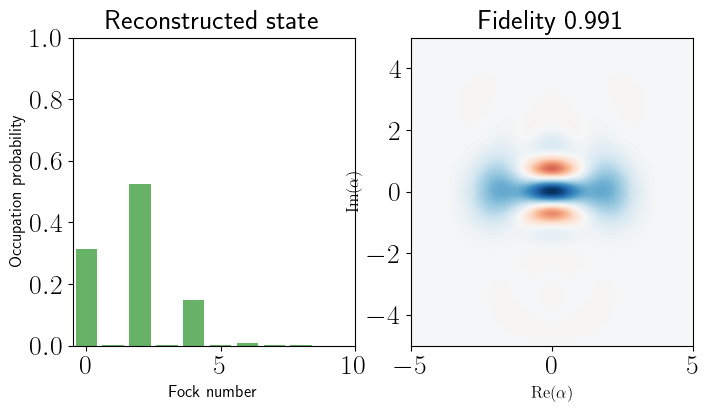

In [14]:
%%time

# get histograms of measurement data
b_all = Parallel(n_jobs=nangles, verbose=1, backend="loky")(delayed(get_measurements_hist_Nmeas_const)(rotangl,theta_int, kappa, n_init) for rotangl in thetas)

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

def get_adjusted_op(i,j):
    op = np.zeros((N_large,N_large), dtype=np.complex64)
    for n in range(N_large):
        for m in range(N_large):
            for k in range(N_large-max(m,n)):
                op += B(m,k,eta)*B(n,k,eta)*Pis[i*Nbins + j][m,n] * np.outer(basis_vectors[n+k], basis_vectors[m+k])#
    return op

op_list = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(get_adjusted_op)(i,j) for i in range(nangles) for j in range(Nbins))        

    ### Construct the matrix A in $A\vec\rho=\vec b$
    #From `Pis` and `basis_dms`.
    
def func(index, a):
        return np.trace(op_list[index[0]][:N,:N] @ basis_dms_cut[index[1]])
    
A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))
    
A = np.reshape(A_p, (len(Pis), N*N))

X = cp.Variable((N,N), hermitian=True)

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

f=fidelity(reconstructed_rho, initial_cavity)**2

fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f));